# Circular flow in a district heating grid

This example shows how to set up and solve the following network:

<img src="pics/heat.png">

In this example, we will not only calculate the pressure and velocity distribution in the network, but also determine the temperature levels. The pump feeds fluid of a given temperature into the grid. Due to losses, the temperature will fall. The heat exchanger removes more heat from the network. On its way back to the pump, the temperature will fall further. 

The network is based on the topology of a district heating grid, where the fluid returns to the pump after the consumers (heat exchangers) have been supplied.

To set up this network, at first, the pandapipes package has to be imported. Additionally, a net container is created and, at the same time, water as a fluid is chosen.

In [11]:
import pandapipes as pp

#create empty net
net = pp.create_empty_network(fluid ="water")

Note that the flow of the example network flows in a closed loop. We will need four junctions.

In [12]:
j1 = pp.create_junction(net, pn_bar=5, tfluid_k=293.15, name="junction 1")
j2 = pp.create_junction(net, pn_bar=5, tfluid_k=293.15, name="junction 2")
j3 = pp.create_junction(net, pn_bar=5, tfluid_k=293.15, name="junction 3")
j4 = pp.create_junction(net, pn_bar=5, tfluid_k=293.15, name="junction 4")

Now, the pump is created. The type of pump we choose needs a mass flow, a pressure level and a temperature as input. Note that the circular pump is a component, which internally consists of an external grid,connected to the junction specified via the from_junction-parameter and a sink, connected to the junction specified via the to_junction-parameter.

However, the internal structure is not visible to the user, so that the circular pump component supplies a fluid flow with the specified properties.

In [13]:
pp.create_circ_pump_const_mass_flow(net, from_junction=j1,to_junction=j4,p_bar=5, mdot_kg_per_s=20, t_k=273.15+35)

0

Next, the heat exchanger component is created. The most important parameter for this component is the heatflow, which is removed from the net. A positive value of qext_w corresponds to a heat flow which is leaving the system.

In [14]:
pp.create_heat_exchanger(net, from_junction=j2,to_junction=j3,diameter_m=200e-3,qext_w = 100000)

0

The following commands defines the pipes between the components. Each pipe will consist of five internal sections in order to improve the spatial resolution for the temperature calculation. The parameter text_k specifies the ambient temperature on the outside of the pipe. It is used to calculate energy losses.

In [15]:
pp.create_pipe_from_parameters(net, from_junction=j1, to_junction=j2, length_km=1, diameter_m=200e-3, k_mm=.1, alpha_w_per_m2k=10, sections = 5, text_k=293)
pp.create_pipe_from_parameters(net, from_junction=j3, to_junction=j4, length_km=1, diameter_m=200e-3, k_mm=.1, alpha_w_per_m2k=10, sections = 5, text_k=293)

1


We now run a pipe flow. 


In [16]:
pp.pipeflow(net, mode='all')

By default, only the pressure and velocity distribution is calculated by the pipeflow function. If the mode parameter is set to "all", the heat transfer calculation is started automatically after the hydraulics computation. Computed mass flows are used as an input for the temperature calculation. After the computation, you can check the results for junctions and pipes:

In [17]:
net.res_junction

,p_bar,t_k
0,5.000000,308.150000
1,4.825502,307.054167
2,4.825502,305.859228
3,4.651003,304.929092


Note that a constant heat flow is extracted via the heat exchanger between nodes 2 and 3. Heat losses due to the ambient temperature level are not taken into account. These are only included in the pipe components. This also means that - if the extracted heat flow is large enough - the temperature level behind the heat exchanger might be lower than the ambient temperature level. A way to avoid this behaviour would be to create a controller which defines a function for the extracted heat in dependence of the ambient temperature.

In [18]:
net.res_pipe

,v_mean_m_per_s,p_from_bar,p_to_bar,t_from_k,t_to_k,mdot_from_kg_per_s,mdot_to_kg_per_s,vdot_norm_m3_per_s,reynolds,lambda
0,0.637784,5.000000,4.825502,308.150000,307.054167,20.0,-20.0,0.020117,127497.350871,0.017191
1,0.637784,4.825502,4.651003,305.859228,304.929092,20.0,-20.0,0.020103,127497.350871,0.017191


The command above shows the results for the pipe components. The temperatures of the adjacent junctions are displayed. Due to heat losses, the temperatures at the to-nodes is lower than the temperatures at the from-nodes. Note also that the junctions are not equal to the internal nodes, introduced by the pipe sections we defined. To display the temperatures at the internal nodes, we can retrieve the internal node values with the following commands:

In [19]:
from pandapipes.component_models import Pipe
pipe_results = Pipe.get_internal_results(net, [0])

The parameters of the get_internal_results function correspond to the net and the pipes we want to evaluate. In this case, only the results of pipe zero are retrieved. The returned value stored in pipe_results is a dictionary, containing fields for the pressure, the velocity and the temperature. The dictionary can either be used for own evaluations now or it can be used to plot the results over the pipe length:


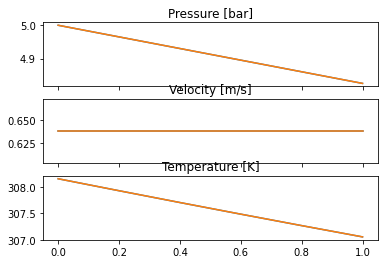

In [20]:
Pipe.plot_pipe(net,0, pipe_results)

We can see that the pressure level falls due to friction. As the fluid is incompressible, the velocity remains constant over the pipe length. Because the temperature level at the pipe entry is higher than the ambient temperature, the temperature level decreases.